# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/dhingratul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dhingratul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/got1.txt'...
Corpus is now 1770659 characters long

Reading 'data/got2.txt'...
Corpus is now 4071041 characters long

Reading 'data/got3.txt'...
Corpus is now 6391405 characters long

Reading 'data/got4.txt'...
Corpus is now 8107945 characters long

Reading 'data/got5.txt'...
Corpus is now 9719485 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
[u'Heraldic', u'crest', u'by', u'Virginia', u'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2017-11-03 17:24:34,728 : INFO : collecting all words and their counts
2017-11-03 17:24:34,731 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-03 17:24:34,783 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2017-11-03 17:24:34,812 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2017-11-03 17:24:34,841 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2017-11-03 17:24:34,869 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2017-11-03 17:24:34,897 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2017-11-03 17:24:34,926 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2017-11-03 17:24:34,957 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2017-11-03 17:24:34,988 : INFO : PROGRESS: at 

In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences, total_words=token_count, epochs=100)

2017-11-03 17:24:40,429 : INFO : training model with 8 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-11-03 17:24:41,447 : INFO : PROGRESS: at 0.28% words, 390738 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:42,455 : INFO : PROGRESS: at 0.57% words, 398566 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:43,464 : INFO : PROGRESS: at 0.88% words, 408293 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:44,464 : INFO : PROGRESS: at 1.19% words, 415953 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:45,472 : INFO : PROGRESS: at 1.51% words, 421618 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:46,488 : INFO : PROGRESS: at 1.82% words, 423497 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:47,492 : INFO : PROGRESS: at 2.14% words, 425348 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:48,500 : INFO : PROGRESS: at 2.43% words, 423913 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:24:49,526 : INFO : PROGRESS: at 2.73

2017-11-03 17:26:02,585 : INFO : PROGRESS: at 23.74% words, 405875 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:03,595 : INFO : PROGRESS: at 24.03% words, 405845 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:04,603 : INFO : PROGRESS: at 24.33% words, 406040 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:05,605 : INFO : PROGRESS: at 24.62% words, 405985 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:06,608 : INFO : PROGRESS: at 24.92% words, 406172 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:07,613 : INFO : PROGRESS: at 25.23% words, 406528 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:08,616 : INFO : PROGRESS: at 25.55% words, 406901 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:09,650 : INFO : PROGRESS: at 25.87% words, 407286 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:10,677 : INFO : PROGRESS: at 26.20% words, 407688 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:26:11,681 : INFO : PROGRESS: at 26.53% words, 408284 words/s, in_qsize 16, ou

2017-11-03 17:27:25,903 : INFO : PROGRESS: at 47.57% words, 403814 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:26,908 : INFO : PROGRESS: at 47.84% words, 403648 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:27,914 : INFO : PROGRESS: at 48.12% words, 403567 words/s, in_qsize 15, out_qsize 0
2017-11-03 17:27:28,924 : INFO : PROGRESS: at 48.39% words, 403400 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:29,935 : INFO : PROGRESS: at 48.66% words, 403223 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:30,958 : INFO : PROGRESS: at 48.93% words, 403015 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:31,971 : INFO : PROGRESS: at 49.22% words, 402972 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:32,974 : INFO : PROGRESS: at 49.51% words, 403052 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:33,979 : INFO : PROGRESS: at 49.78% words, 402895 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:27:34,982 : INFO : PROGRESS: at 50.07% words, 402916 words/s, in_qsize 16, ou

2017-11-03 17:28:48,972 : INFO : PROGRESS: at 71.66% words, 404920 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:49,979 : INFO : PROGRESS: at 71.97% words, 405041 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:50,980 : INFO : PROGRESS: at 72.25% words, 404995 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:51,987 : INFO : PROGRESS: at 72.55% words, 405063 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:52,994 : INFO : PROGRESS: at 72.83% words, 404977 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:54,011 : INFO : PROGRESS: at 73.12% words, 404991 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:55,012 : INFO : PROGRESS: at 73.43% words, 405069 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:56,015 : INFO : PROGRESS: at 73.72% words, 405081 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:57,046 : INFO : PROGRESS: at 74.02% words, 405102 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:28:58,075 : INFO : PROGRESS: at 74.32% words, 405134 words/s, in_qsize 16, ou

2017-11-03 17:30:12,369 : INFO : PROGRESS: at 95.28% words, 403158 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:13,373 : INFO : PROGRESS: at 95.56% words, 403126 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:14,383 : INFO : PROGRESS: at 95.86% words, 403155 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:15,390 : INFO : PROGRESS: at 96.14% words, 403092 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:16,402 : INFO : PROGRESS: at 96.41% words, 403028 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:17,417 : INFO : PROGRESS: at 96.70% words, 403007 words/s, in_qsize 15, out_qsize 0
2017-11-03 17:30:18,433 : INFO : PROGRESS: at 96.99% words, 403025 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:19,436 : INFO : PROGRESS: at 97.26% words, 402949 words/s, in_qsize 15, out_qsize 0
2017-11-03 17:30:20,439 : INFO : PROGRESS: at 97.55% words, 402965 words/s, in_qsize 16, out_qsize 0
2017-11-03 17:30:21,472 : INFO : PROGRESS: at 97.82% words, 402832 words/s, in_qsize 16, ou

140444670

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2017-11-03 17:30:50,288 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2017-11-03 17:30:50,291 : INFO : not storing attribute syn0norm
2017-11-03 17:30:50,294 : INFO : not storing attribute cum_table
2017-11-03 17:30:50,550 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [23]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-11-03 17:30:52,240 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2017-11-03 17:30:52,318 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2017-11-03 17:30:52,318 : INFO : setting ignored attribute syn0norm to None
2017-11-03 17:30:52,319 : INFO : setting ignored attribute cum_table to None
2017-11-03 17:30:52,319 : INFO : loaded trained/thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,fawn,-3.023245,1.586061
1,raining,-0.333793,1.368858
2,writings,-0.200781,1.421213
3,Ysilla,-1.495032,-1.472098
4,Rory,-0.199616,2.525259
5,hordes,-0.957941,-0.795697
6,mustachio,-0.363201,3.445927
7,Greyjoy,-4.787770,1.445625
8,yellow,-1.389056,4.161322
9,four,-3.050213,4.122566


In [29]:
sns.set_context("poster")

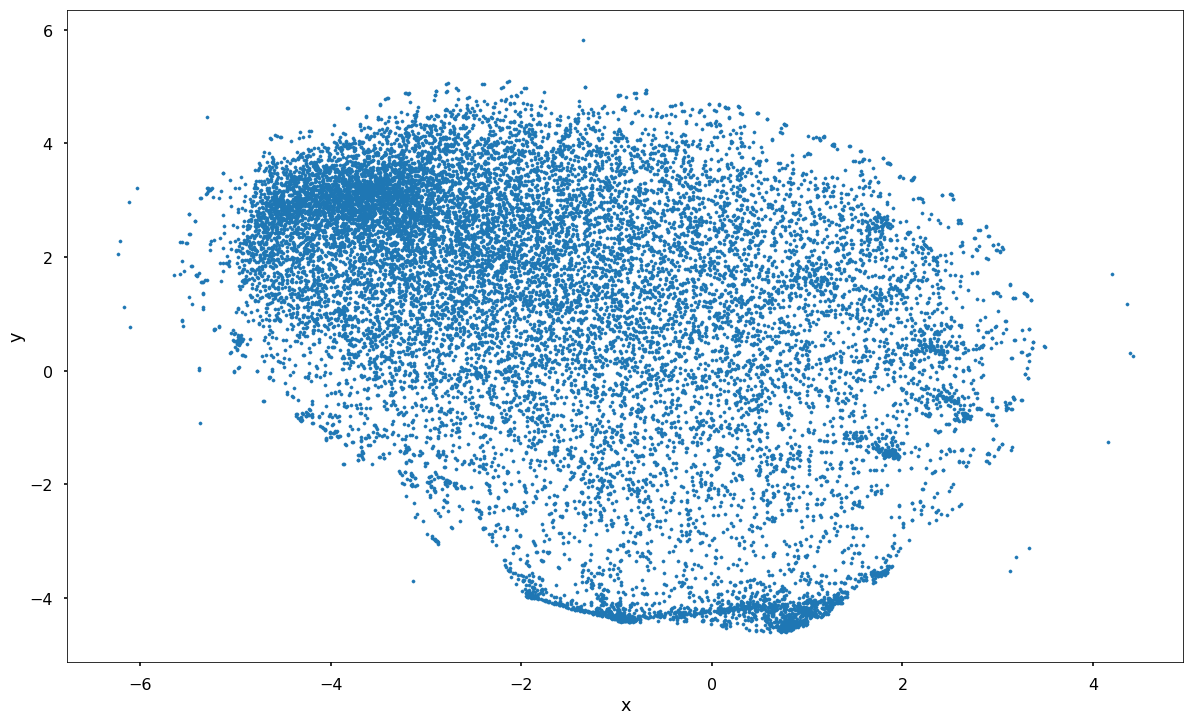

In [30]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [47]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

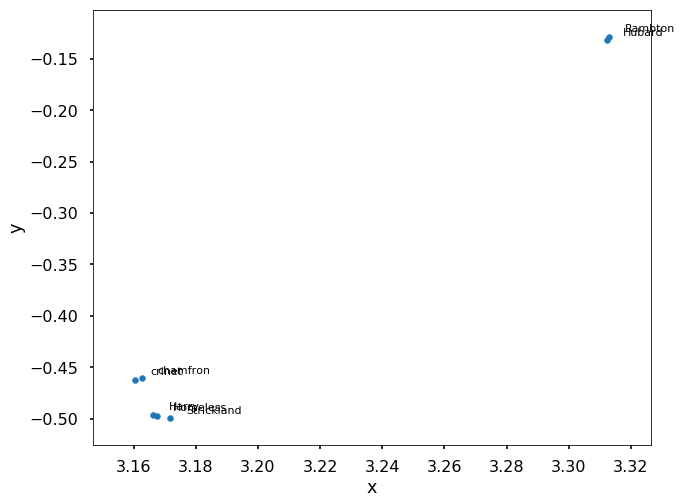

In [53]:
plot_region(x_bounds=(3, 3.5), y_bounds=(-0.5, -0.1))

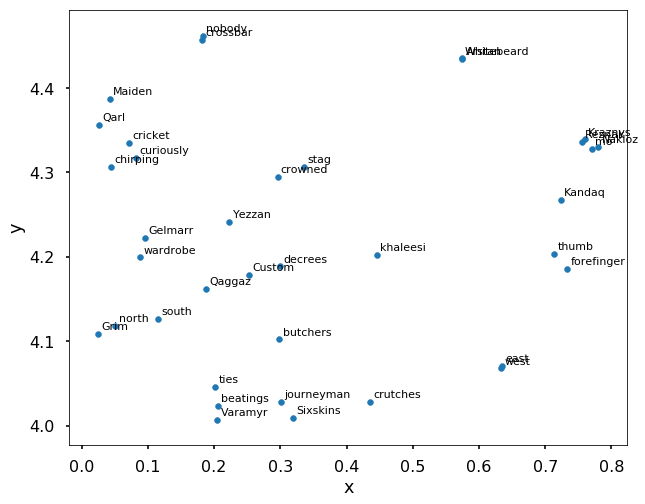

In [54]:
plot_region(x_bounds=(0.0, 1.0), y_bounds=(4.0, 4.5))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

### Explore semantic similarities between book characters

**Words closest to the given word**

In [55]:
thrones2vec.most_similar("Stark")

[(u'Eddard', 0.6536116600036621),
 (u'Robb', 0.4136900305747986),
 (u'Winterfell', 0.39889511466026306),
 (u'Catelyn', 0.39725369215011597),
 (u'Jammos', 0.3955981135368347),
 (u'Snowbeard', 0.39246875047683716),
 (u'SHIREI', 0.3916860520839691),
 (u'ROSLIN', 0.3824983537197113),
 (u'Edrick', 0.3818821907043457),
 (u'divulge', 0.3749784529209137)]

In [56]:
thrones2vec.most_similar("Aerys")

[(u'II', 0.5039679408073425),
 (u'Targaryen', 0.43541157245635986),
 (u'Mad', 0.3936169147491455),
 (u'Jaehaerys', 0.3489644229412079),
 (u'Defiance', 0.34277307987213135),
 (u'King', 0.34056535363197327),
 (u'Mern', 0.337368905544281),
 (u'Robert', 0.33486565947532654),
 (u'LYANNA', 0.33344587683677673),
 (u'Aegon', 0.3325141966342926)]

In [57]:
thrones2vec.most_similar("direwolf")

[(u'SHAGGYDOG', 0.447177916765213),
 (u'Ghost', 0.438210666179657),
 (u'GHOST', 0.4341866374015808),
 (u'WIND', 0.4307864308357239),
 (u'EDDISON', 0.42844054102897644),
 (u'Asleep', 0.4102153778076172),
 (u'wolf', 0.4033767580986023),
 (u'TOLLETT', 0.4024589955806732),
 (u'DOLOROUS', 0.40199044346809387),
 (u'wolfhounds', 0.3956485390663147)]

**Linear relationships between word pairs**

In [58]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [59]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Wood is related to Riverrun
Jaime is related to sword, as fermented is related to wine
Arya is related to Nymeria, as servants is related to dragons


u'servants'